In [1]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

Using TensorFlow backend.


In [2]:
resnet_weights_path = 'C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/Resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_weights_path="C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/VGG16/vgg16_weights_tf_dim_ordering_tf_kernels.h5"

In [3]:
print(os.listdir("C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive"))


['174469_505351_bundle_archive.zip', 'data', 'Resnet50', 'test', 'train', 'VGG16']


In [4]:
def Dataset_loader(DIR,RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img)/255.)
    return IMG


In [6]:
benign_train = np.array(Dataset_loader('C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/train/benign',224))
malign_train = np.array(Dataset_loader('C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/train/malignant',224))
benign_test = np.array(Dataset_loader('C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/test/benign',224))
malign_test = np.array(Dataset_loader('C:/Users/hardikarora/Desktop/Loveleen Journal/My Journal/174469_505351_bundle_archive/test/malignant',224))

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 392.97it/s]


In [7]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

In [8]:
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [9]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

In [10]:
x_train=X_train[1000:]
x_val=X_train[:1000]
y_train=Y_train[1000:]
y_val=Y_train[:1000]

In [11]:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

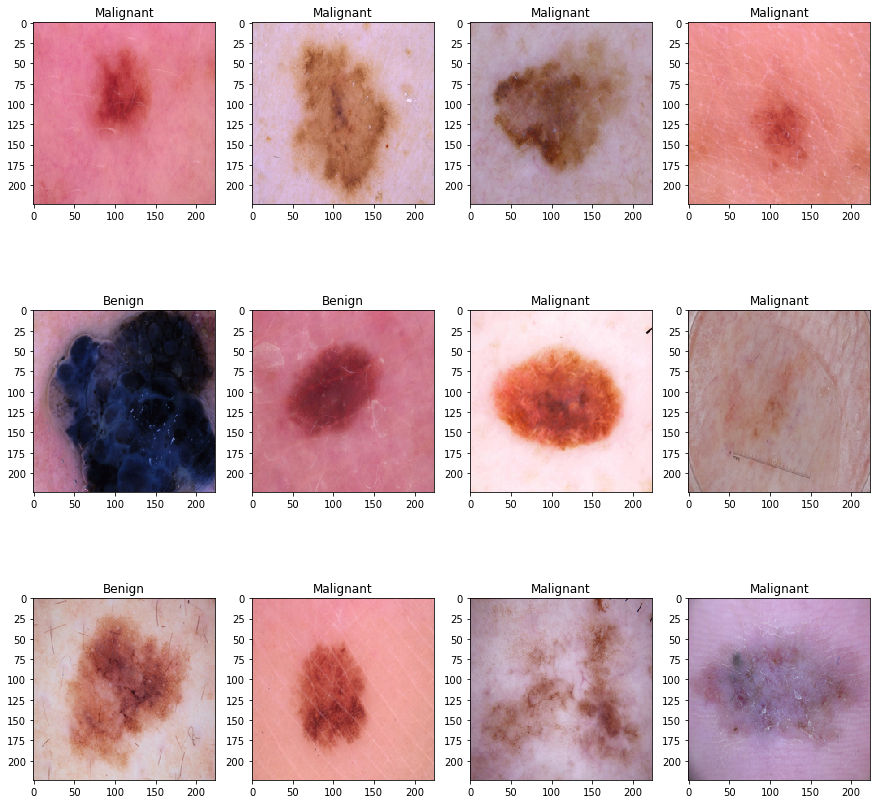

In [12]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [14]:
model = Sequential()


In [15]:
model.add(ResNet50(include_top=False,input_tensor=None,input_shape=(224,224,3),pooling='avg',classes=2, weights='imagenet'))


94773248/94765736 [==============================] - 10s 0us/step


In [16]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

In [17]:
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

In [17]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.7)

In [19]:
batch_size=32
epochs=35
History = model.fit(x_train,y_train,batch_size=batch_size,validation_data=(x_val,y_val),
                              epochs= epochs, steps_per_epoch=x_train.shape[0]//batch_size,verbose=1
                             ) 

Epoch 1/35
51/51 [==============================] - 113s 2s/step - loss: 0.8370 - accuracy: 0.5227 - val_loss: 0.7288 - val_accuracy: 0.4630
Epoch 2/35
51/51 [==============================] - 102s 2s/step - loss: 0.8164 - accuracy: 0.5090 - val_loss: 0.6831 - val_accuracy: 0.7130
Epoch 3/35
51/51 [==============================] - 101s 2s/step - loss: 0.7705 - accuracy: 0.5414 - val_loss: 0.6816 - val_accuracy: 0.5430
Epoch 4/35
51/51 [==============================] - 101s 2s/step - loss: 0.7668 - accuracy: 0.5153 - val_loss: 0.7035 - val_accuracy: 0.5370
Epoch 5/35
51/51 [==============================] - 101s 2s/step - loss: 0.7407 - accuracy: 0.5470 - val_loss: 0.7079 - val_accuracy: 0.5370
Epoch 6/35
51/51 [==============================] - 101s 2s/step - loss: 0.7268 - accuracy: 0.5277 - val_loss: 0.7225 - val_accuracy: 0.5370
Epoch 7/35
51/51 [==============================] - 101s 2s/step - loss: 0.7372 - accuracy: 0.5402 - val_loss: 0.7642 - val_accuracy: 0.5370
Epoch 8/35
51

In [20]:
lists=[]
y_pred = model.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i][0]>0.5:
        lists.append(1)
    else:
        lists.append(0)
        
print(accuracy_score(Y_test, lists))

0.5454545454545454


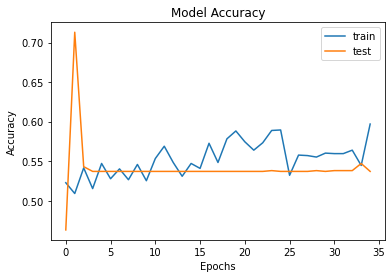

In [21]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [22]:
confusion_matrix(Y_test, lists) 

array([[360,   0],
       [300,   0]], dtype=int64)

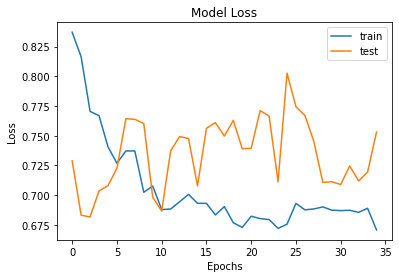

In [23]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

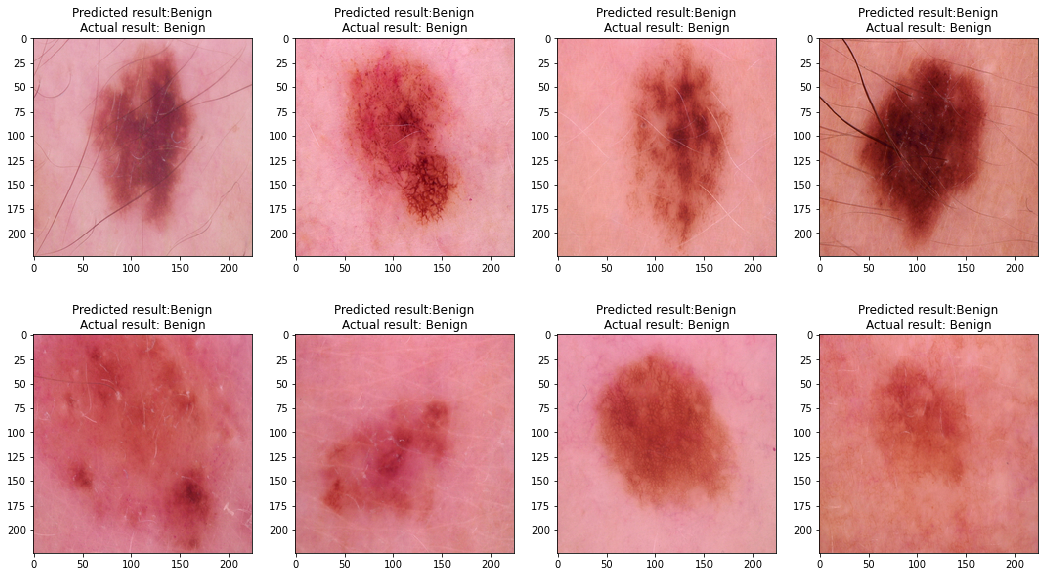

In [24]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(Y_test[i]==lists[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not Y_test[i]==lists[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(lists[prop_class[i]])
                       +"\n"+"Actual result: "+ Transfername(Y_test[prop_class[i]]))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()


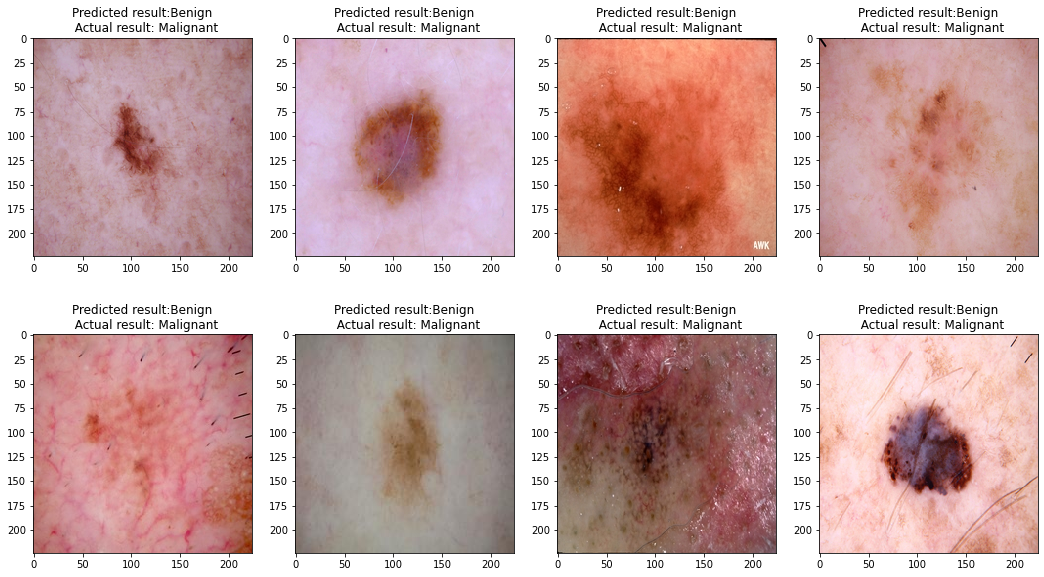

In [25]:
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2
for i in range(len(mis_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(lists[mis_class[i]])
                   +"\n"+"  Actual result: "+ Transfername(Y_test[mis_class[i]]))
    plt.imshow(X_test[mis_class[i]], interpolation='nearest')
plt.show()
